## General Information

This notebook is used to train a simple neural network model to predict the chemistry in the barite benchmark (50x50 grid). The training data is stored in the repository using **git large file storage** and can be downloaded after the installation of git lfs using the `git lfs pull` command.

It is then recommended to create a Python environment using miniconda. The necessary dependencies are contained in `environment.yml` and can be installed using `conda env create -f environment.yml`.

The data set is divided into a design and result part and consists of the iterations of a reference simulation. The design part of the data set contains the chemical concentrations at time $t$ and the result part at time $t+1$, which are to be learned by the model.

## Setup Libraries

In [2]:
import keras
import h5py
import numpy as np
import pandas as pd
import time
import sklearn.model_selection as sk
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import os
from preprocessing import *

## Define parameters

In [3]:
dtype = "float32"
activation = "relu"

lr = 0.001
batch_size = 512
epochs = 50 # default 400 epochs

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=2000,
    decay_rate=0.9,
    staircase=True
)

optimizer_simple = keras.optimizers.Adam(learning_rate=lr_schedule)
optimizer_large = keras.optimizers.Adam(learning_rate=lr_schedule)

loss = keras.losses.Huber()

sample_fraction = 0.8

## Setup the model

In [4]:
model_simple = keras.Sequential(
    [
        keras.Input(shape = (12,), dtype = "float32"),
        keras.layers.Dense(units = 128, activation = "relu", dtype = "float32"),
        keras.layers.Dense(units = 128, activation = "relu", dtype = "float32"),
        keras.layers.Dense(units = 12, dtype = "float32")
    ]
)

model_simple.compile(optimizer=optimizer_simple, loss = loss)
model_simple.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,724 (77.05 KB)

 Trainable params: 19,724 (77.05 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model_large =   keras.Sequential(
    [keras.layers.Input(shape=(12,), dtype=dtype),
     keras.layers.Dense(512, activation='relu', dtype=dtype),
     keras.layers.Dense(1024, activation='relu', dtype=dtype),
     keras.layers.Dense(512, activation='relu', dtype=dtype),
     keras.layers.Dense(12, dtype=dtype)
     ])

model_large.compile(optimizer=optimizer_large, loss = loss)
model_large.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,062,924 (4.05 MB)

 Trainable params: 1,062,924 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

## Define some functions and helper classes

In [6]:
def Safelog(val):
    # get range of vector
    if val > 0:
        return np.log10(val)
    elif val < 0:
        return -np.log10(-val)
    else:
        return 0

def Safeexp(val):
    if val > 0:
        return -10 ** -val
    elif val < 0:
        return 10 ** val
    else:
        return 0

In [7]:
# ? Why does the charge is using another logarithm than the other species

func_dict_in = {
    "H" : np.log1p,
    "O" : np.log1p,
    "Charge" : Safelog,
    "H_0_" : np.log1p,
    "O_0_" : np.log1p,
    "Ba" : np.log1p,
    "Cl" : np.log1p,
    "S_2_" : np.log1p,
    "S_6_" : np.log1p,
    "Sr" : np.log1p,
    "Barite" : np.log1p,
    "Celestite" : np.log1p,
}

func_dict_out = {
    "H" : np.expm1,
    "O" : np.expm1,
    "Charge" : Safeexp,
    "H_0_" : np.expm1,
    "O_0_" : np.expm1,
    "Ba" : np.expm1,
    "Cl" : np.expm1,
    "S_2_" : np.expm1,
    "S_6_" : np.expm1,
    "Sr" : np.expm1,
    "Barite" : np.expm1,
    "Celestite" : np.expm1,
}


## Read data from `.h5` file and convert it to a `pandas.DataFrame`

In [99]:
# os.chdir('/mnt/beegfs/home/signer/projects/model-training')
data_file = h5py.File("Barite_50_Data_training.h5")

design = data_file["design"]
results = data_file["result"]

df_design = pd.DataFrame(np.array(design["data"]).transpose(), columns = design["names"].asstr())
df_results = pd.DataFrame(np.array(results["data"]).transpose(), columns = results["names"].asstr())

data_file.close()

In [100]:
df_design

H          O        Charge           H_0_          O_0_  \
0        111.012434  55.508192 -7.779554e-09   2.697041e-26  2.210590e-15   
1        111.012434  55.508427 -4.736083e-09   1.446346e-26  2.473481e-15   
2        111.012434  55.508691 -1.311169e-09   3.889826e-28  2.769320e-15   
3        111.012434  55.508698 -1.220023e-09   1.442658e-29  2.777193e-15   
4        111.012434  55.508699 -1.216643e-09   5.350528e-31  2.777485e-15   
...             ...        ...           ...            ...           ...   
2502495  111.012434  55.507488  3.573728e-09  5.424062e-145  1.375204e-10   
2502496  111.012434  55.507501  3.494007e-09  2.011675e-146  1.377139e-10   
2502497  111.012434  55.507512  3.429764e-09  7.460897e-148  1.377819e-10   
2502498  111.012434  55.507520  3.381745e-09  2.767237e-149  1.371144e-10   
2502499  111.012434  55.507525  3.348864e-09  5.321610e-151  1.376026e-10   

                   Ba            Cl           S_2_      S_6_        Sr  \
0        2.041069e-02  4.082138e-02   0.000000e+00  0.000494  0.000494   
1        1.094567e-02  2.189133e-02   0.000000e+00  0.000553  0.000553   
2        2.943745e-04  5.887491e-04   0.000000e+00  0.000619  0.000619   
3        1.091776e-05  2.183551e-05   0.000000e+00  0.000620  0.000620   
4        4.049176e-07  8.098352e-07   0.000000e+00  0.000620  0.000620   
...               ...           ...            ...       ...       ...   
2502495  9.953520e-07  2.266555e-03  5.509534e-149  0.000318  0.001450   
2502496  9.817216e-07  2.217997e-03  2.043375e-150  0.000321  0.001429   
2502497  9.706451e-07  2.179066e-03  7.578467e-152  0.000324  0.001412   
2502498  9.621074e-07  2.149820e-03  2.810844e-153  0.000326  0.001400   
2502499  9.564401e-07  2.129912e-03  5.405468e-155  0.000327  0.001391   

         Barite  Celestite  
0         0.001   1.000000  
1         0.001   1.000000  
2         0.001   1.000000  
3         0.001   1.000000  
4         0.001   1.000000  
...         ...        ...  
2502495   0.001   1.000014  
2502496   0.001   1.000010  
2502497   0.001   1.000006  
2502498   0.001   1.000004  
2502499   0.001   1.000001  

[2502500 rows x 12 columns]

## Classify each cell with kmeans

In [16]:
# widget with slider for the index

class_label_design = np.array([])
class_label_result = np.array([])


i = len(df_design) / 2500
for i in range(0,252):
    field_design = np.array(df_design['Barite'][(i*2500):(i*2500+2500)]).reshape(50,50)
    field_result = np.array(df_results['Barite'][(i*2500):(i*2500+2500)]).reshape(50,50)
    
    kmeans_design = KMeans(n_clusters=2, random_state=0).fit(field_design.reshape(-1,1))
    kmeans_result = KMeans(n_clusters=2, random_state=0).fit(field_result.reshape(-1,1))
    
    class_label_design = np.append(class_label_design.astype(int), kmeans_design.labels_)
    class_label_result = np.append(class_label_result.astype(int), kmeans_result.labels_)
    


class_label_design = pd.DataFrame(class_label_design, columns = ["Class"])
class_label_result = pd.DataFrame(class_label_result, columns = ["Class"])


/Users/hannessigner/miniconda3/envs/ai/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [17]:
if("Class" in df_design.columns and "Class" in df_results.columns):
    print("Class column already exists")
else:
    df_design = pd.concat([df_design, class_label_design], axis=1)
    df_results = pd.concat([df_results, class_label_design], axis=1)

In [18]:
counter = Counter(df_design.iloc[:,-1])
print("Amount class 0:", counter[0] / (counter[0] + counter[1]) )
print("Amount class 1:", counter[1] / (counter[0] + counter[1]) )


Amount class 0: 0.9520126984126984
Amount class 1: 0.047987301587301585


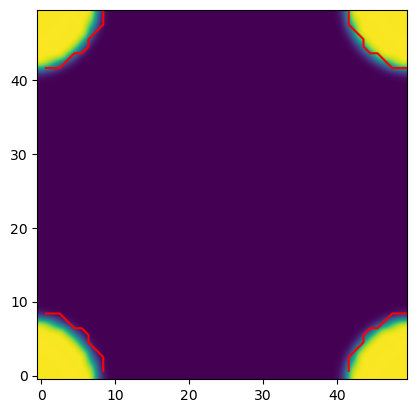

In [25]:
i=251

plt.imshow(np.array(df_results['Barite'][(i*2500):(i*2500+2500)]).reshape(50,50), interpolation='bicubic', origin='lower')
plt.contour(np.array(df_results['Class'][(i*2500):(i*2500+2500)]).reshape(50,50), levels=[0.1], colors='red', origin='lower')

In [26]:
df_design['Class threshold'] = df_design['Barite'] > 0.49


In [27]:
df_design['Class'][df_design["Class threshold"] == True].sum() / df_design['Class threshold'][df_design["Class threshold"] == True].sum()

0.9991298042059463

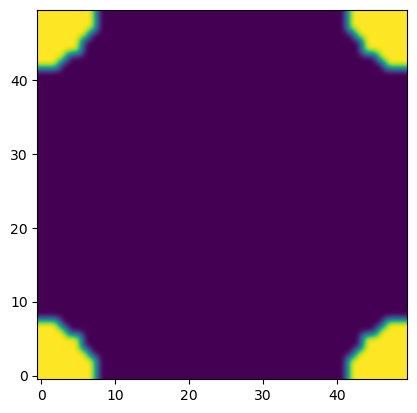

In [29]:
i = 251
plt.imshow(np.array(df_design['Class threshold'][(i*2500):(i*2500+2500)]).reshape(50,50), interpolation='bicubic', origin='lower')

## Split into Training and Testing datsets

In [30]:
X_train, X_test, y_train, y_test = sk.train_test_split(df_design, df_results, test_size = 0.2)

## Perform Over and Under Sampling on dataset to balance classes

In [31]:
def balancer(design, target, strategy, sample_fraction=0.5):
    counter = Counter(design.iloc[:,-1])
    print("Amount class 0 before:", counter[0] / (counter[0] + counter[1]) )
    print("Amount class 1 before:", counter[1] / (counter[0] + counter[1]) )
    
    number_features = (df_design.columns != "Class").sum()
    if("Class" not in design.columns):
        if("Class" in target.columns):
            classes = target['Class']
        else:
            raise("No class column found")
    else:
        classes = design['Class']
        df = pd.concat([design.loc[:,design.columns != "Class"], target.loc[:, design.columns != "Class"], classes], axis=1)
        
    if strategy == 'smote':
        print("Using SMOTE strategy")
        smote = SMOTE(sampling_strategy=sample_fraction)
        df_resampled, classes_resampled = smote.fit_resample(df.loc[:, df.columns != "Class"], df.loc[:, df.columns == "Class"])
        
    elif strategy == 'over':
        print("Using Oversampling")
        over = RandomOverSampler()
        df_resampled, classes_resampled = over.fit_resample(df.loc[:, df.columns != "Class"], df.loc[:, df.columns == "Class"])
        
    elif strategy == 'under':
        print("Using Undersampling")
        under = RandomUnderSampler()
        df_resampled, classes_resampled = under.fit_resample(df.loc[:, df.columns != "Class"], df.loc[:, df.columns == "Class"])

    counter = Counter(classes_resampled["Class"])
    print("Amount class 0 after:", counter[0] / (counter[0] + counter[1]) )
    print("Amount class 1 after:", counter[1] / (counter[0] + counter[1]) )
    
    design_resampled = pd.concat([df_resampled.iloc[:,0:number_features], classes_resampled], axis=1)
    target_resampled = pd.concat([df_resampled.iloc[:,number_features:], classes_resampled], axis=1)
    
    return design_resampled, target_resampled            

In [32]:
X_train, y_train = balancer(X_train, y_train, 'over')

Amount class 0 before: 0.9563730158730158
Amount class 1 before: 0.043626984126984125


IndexError: Boolean index has wrong length: 11 instead of 10

## Define Scaling and Normalization Functions

In [88]:
def log_scale(df_design, df_result, func_dict):
    
    df_design = df_design.copy()
    df_result = df_result.copy()
    
    for key in df_design.keys():
        if key != "Class":
            df_design[key] = np.vectorize(func_dict[key])(df_design[key])
            df_result[key] = np.vectorize(func_dict[key])(df_result[key])
        
    return df_design, df_result

# Get minimum and maximum values for each column
def get_min_max(df_design, df_result):
    
    min_vals_des = df_design.min()
    max_vals_des = df_design.max()
    
    min_vals_res = df_result.min()
    max_vals_res = df_result.max()

    # minimum of input and output data to get global minimum/maximum
    data_min = np.minimum(min_vals_des, min_vals_res).to_dict()
    data_max = np.maximum(max_vals_des, max_vals_res).to_dict()

    return data_min, data_max


In [101]:
df_design_log, df_results_log = log_scale(df_design, df_results, func_dict_in)
data_min_log, data_max_log = get_min_max(df_design_log, df_results_log)

In [102]:
df_design

H          O        Charge           H_0_          O_0_  \
0        111.012434  55.508192 -7.779554e-09   2.697041e-26  2.210590e-15   
1        111.012434  55.508427 -4.736083e-09   1.446346e-26  2.473481e-15   
2        111.012434  55.508691 -1.311169e-09   3.889826e-28  2.769320e-15   
3        111.012434  55.508698 -1.220023e-09   1.442658e-29  2.777193e-15   
4        111.012434  55.508699 -1.216643e-09   5.350528e-31  2.777485e-15   
...             ...        ...           ...            ...           ...   
2502495  111.012434  55.507488  3.573728e-09  5.424062e-145  1.375204e-10   
2502496  111.012434  55.507501  3.494007e-09  2.011675e-146  1.377139e-10   
2502497  111.012434  55.507512  3.429764e-09  7.460897e-148  1.377819e-10   
2502498  111.012434  55.507520  3.381745e-09  2.767237e-149  1.371144e-10   
2502499  111.012434  55.507525  3.348864e-09  5.321610e-151  1.376026e-10   

                   Ba            Cl           S_2_      S_6_        Sr  \
0        2.041069e-02  4.082138e-02   0.000000e+00  0.000494  0.000494   
1        1.094567e-02  2.189133e-02   0.000000e+00  0.000553  0.000553   
2        2.943745e-04  5.887491e-04   0.000000e+00  0.000619  0.000619   
3        1.091776e-05  2.183551e-05   0.000000e+00  0.000620  0.000620   
4        4.049176e-07  8.098352e-07   0.000000e+00  0.000620  0.000620   
...               ...           ...            ...       ...       ...   
2502495  9.953520e-07  2.266555e-03  5.509534e-149  0.000318  0.001450   
2502496  9.817216e-07  2.217997e-03  2.043375e-150  0.000321  0.001429   
2502497  9.706451e-07  2.179066e-03  7.578467e-152  0.000324  0.001412   
2502498  9.621074e-07  2.149820e-03  2.810844e-153  0.000326  0.001400   
2502499  9.564401e-07  2.129912e-03  5.405468e-155  0.000327  0.001391   

         Barite  Celestite  
0         0.001   1.000000  
1         0.001   1.000000  
2         0.001   1.000000  
3         0.001   1.000000  
4         0.001   1.000000  
...         ...        ...  
2502495   0.001   1.000014  
2502496   0.001   1.000010  
2502497   0.001   1.000006  
2502498   0.001   1.000004  
2502499   0.001   1.000001  

[2502500 rows x 12 columns]

In [103]:
df_design_log

H         O    Charge           H_0_          O_0_  \
0        4.71861  4.034386  8.109045   2.697041e-26  2.210590e-15   
1        4.71861  4.034390  8.324581   1.446346e-26  2.473481e-15   
2        4.71861  4.034394  8.882341   3.889826e-28  2.769320e-15   
3        4.71861  4.034395  8.913632   1.442658e-29  2.777193e-15   
4        4.71861  4.034395  8.914837   5.350528e-31  2.777485e-15   
...          ...       ...       ...            ...           ...   
2502495  4.71861  4.034373 -8.446878  5.424062e-145  1.375204e-10   
2502496  4.71861  4.034373 -8.456676  2.011675e-146  1.377139e-10   
2502497  4.71861  4.034374 -8.464736  7.460897e-148  1.377819e-10   
2502498  4.71861  4.034374 -8.470859  2.767237e-149  1.371144e-10   
2502499  4.71861  4.034374 -8.475102  5.321610e-151  1.376026e-10   

                   Ba            Cl           S_2_      S_6_        Sr  \
0        2.020518e-02  4.001019e-02   0.000000e+00  0.000494  0.000494   
1        1.088620e-02  2.165516e-02   0.000000e+00  0.000552  0.000552   
2        2.943312e-04  5.885758e-04   0.000000e+00  0.000618  0.000618   
3        1.091770e-05  2.183528e-05   0.000000e+00  0.000620  0.000620   
4        4.049175e-07  8.098349e-07   0.000000e+00  0.000620  0.000620   
...               ...           ...            ...       ...       ...   
2502495  9.953515e-07  2.263990e-03  5.509534e-149  0.000318  0.001449   
2502496  9.817211e-07  2.215541e-03  2.043375e-150  0.000321  0.001428   
2502497  9.706446e-07  2.176695e-03  7.578467e-152  0.000324  0.001411   
2502498  9.621070e-07  2.147512e-03  2.810844e-153  0.000326  0.001399   
2502499  9.564396e-07  2.127647e-03  5.405468e-155  0.000327  0.001390   

           Barite  Celestite  
0        0.001000   0.693147  
1        0.001000   0.693147  
2        0.001000   0.693147  
3        0.001000   0.693147  
4        0.001000   0.693147  
...           ...        ...  
2502495  0.000999   0.693154  
2502496  0.000999   0.693152  
2502497  0.000999   0.693150  
2502498  0.000999   0.693149  
2502499  0.000999   0.693148  

[2502500 rows x 12 columns]

In [74]:
X_train_log, y_train_log = log_scale(X_train, y_train, func_dict_in)
X_test_log, y_test_log = log_scale(X_test, y_test, func_dict_in)

In [16]:
train_min_log, train_max_log = get_min_max(X_train_log, y_train_log)
test_min_log, test_max_log = get_min_max(X_test_log, y_test_log)

In [17]:
def preprocess(data, func_dict, data_min, data_max):
    data = data.copy()
    for key in data.keys():
        if key != "Class":
            data[key] = (data[key] - data_min[key]) / (data_max[key] - data_min[key])

    return data

def postprocess(data, func_dict, data_min, data_max):
    data = data.copy()
    for key in data.keys():
        if key != "Class":
            data[key] = data[key] * (data_max[key] - data_min[key]) + data_min[key]
            data[key] = np.vectorize(func_dict[key])(data[key])
    return data

## Preprocess the data

In [13]:
pp_design = preprocess(df_design_log, func_dict_in, data_min_log, data_max_log)
pp_results = preprocess(df_results_log, func_dict_in, data_min_log, data_max_log)

In [18]:
X_train_preprocess = preprocess(X_train_log, func_dict_in, train_min_log, train_max_log)
y_train_preprocess = preprocess(y_train_log, func_dict_in, train_min_log, train_max_log)

X_test_preprocess = preprocess(X_test_log, func_dict_in, test_min_log, test_max_log)
y_test_preprocess = preprocess(y_test_log, func_dict_in, test_min_log, test_max_log)

## Sample the data

In [61]:
X_train, X_val, y_train, y_val = sk.train_test_split(X_train_preprocess, y_train_preprocess, test_size = 0.1)

## Custom Loss function

In [164]:
def custom_loss_H20(df_design_log, df_result_log, data_min_log, data_max_log, func_dict_out, postprocess):
    df_result = postprocess(df_result_log, func_dict_out, data_min_log, data_max_log)    
    return keras.losses.Huber + np.sum(((df_result['H'] / df_result['O']) - 2)**2)

def loss_wrapper(data_min_log, data_max_log, func_dict_out, postprocess):
    def loss(df_design_log, df_result_log):
        return custom_loss_H20(df_design_log, df_result_log, data_min_log, data_max_log, func_dict_out, postprocess)
    return loss

## Train the model

In [71]:
# measure time
start = time.time()

history = model_simple.fit(X_train.iloc[:, :-1], 
            y_train.iloc[:, :-1], 
            batch_size = batch_size, 
            epochs = 5, 
            validation_data = (X_val.iloc[:,:-1], y_val.iloc[:, :-1])
)

end = time.time()

print("Training took {} seconds".format(end - start))

Epoch 1/5


ValueError: Attr 'Toutput_types' of 'OptionalFromValue' Op passed list of length 0 less than minimum 1.

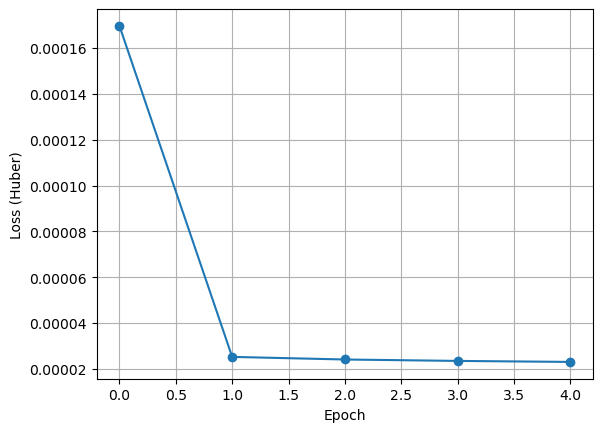

In [146]:
plt.plot(history.history["loss"], "o-", label = "Training Loss")
plt.xlabel("Epoch")
# plt.yscale('log')
plt.ylabel("Loss (Huber)")
plt.grid('on')

plt.savefig("loss_all.png", dpi=300)


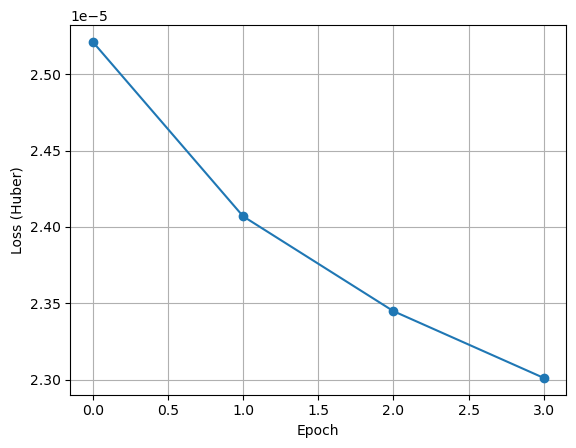

In [147]:
plt.plot(history.history["loss"][1:], "o-", label = "Training Loss")
plt.xlabel("Epoch")
# plt.yscale('log')
plt.ylabel("Loss (Huber)")
plt.grid('on')
plt.savefig("loss_1_to_end.png", dpi=300)


## Test the model

In [31]:
# test on all test data
model_simple.evaluate(X_test_preprocess.iloc[:,:-1], y_test_preprocess.iloc[:, :-1])

15641/15641 ━━━━━━━━━━━━━━━━━━━━ 4s 233us/step - loss: 0.0324


0.032423071563243866

In [32]:
# test on non-reactive data
model_simple.evaluate(X_test_preprocess[X_test_preprocess['Class'] == 0].iloc[:,:-1], y_test_preprocess[X_test_preprocess['Class'] == 0].iloc[:,:-1])

15451/15451 ━━━━━━━━━━━━━━━━━━━━ 4s 234us/step - loss: 0.0313


0.031290605664253235

In [33]:
# test on reactive data
model_simple.evaluate(X_test_preprocess[X_test_preprocess['Class'] == 1].iloc[:,:-1], y_test_preprocess[X_test_preprocess['Class'] == 1].iloc[:, :-1])

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - loss: 0.1246


0.12462512403726578

## Save the model

In [53]:
# Save the model
model.save("Barite_50_Model_additional_species.keras")